# MODFLOW Grid from Scratch with ```Rasterio``` and ```Flopy```
1. Make a modified DEM for MODFLOW
    - Downsample 30m DEM. 
        - Where rivers exist, use the minimum in that cell. 
        - Use cell average everywhere else

In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import math
import matplotlib.pyplot as plt
# Geospatial imports
import fiona
from rasterio.features import rasterize
from rasterio.warp import reproject, Resampling
from rasterio import Affine, transform
# MODFLOW Flopy
import flopy
from flopy.utils.reference import SpatialReference
#Paths
root = r'D:\TreasureValley\notebooks'
sys.path.append(root)
from gridtools import resample,vtorast,rowcol

In [2]:
# Set up grid parameters
dx = dy = 1609.344
xul = 2250706.91 
yul = 1437102

### Import DEM, streams shapes, and layer surfaces into numpy arrays

In [3]:
## Inputs
rast = os.path.join(root,'data','gis','dem.tif')
vect = os.path.join(root,'data','gis','streams_simple.shp')
seds = os.path.join(root,'data','gis','sediments.tif')
basalts = os.path.join(root,'data','gis','basalts.tif')
## 1. Downsample DEM to coarser cell size
DEMavg = resample( rast, dx, method=Resampling.average)
DEMmin = resample( rast, dx, method=Resampling.min)
npDEM = np.copy(DEMavg['raster'])

## 2. Rasterize streams
arr_stream = vtorast( vect, cell_size=dx)['raster']

### 2i. expand streams to have same dimensions as DEM
arr_stream_expand = np.full_like(npDEM,0)
arr_stream_expand[0:arr_stream.shape[0],0:arr_stream.shape[1]] = arr_stream
arr_stream = np.copy(arr_stream_expand)

## 3. Set elevation to minimum cell elevation where stream cells exist 
npDEM[arr_stream> 0] = DEMmin['raster'][arr_stream> 0]

### 3.i Read in basalt and sediment depth rasters. Make the bottom raster with these isopach maps
### Maps digitized from Whitehead, 1992
region = transform.array_bounds(*npDEM.shape,DEMavg['affine'])
dseds = resample(seds, dx, bounds=region, method=Resampling.average)  
dbasalt = resample(basalts, dx, bounds=region, method=Resampling.average)  
DEMbottom2 = npDEM-dseds['raster']-dbasalt['raster']
DEMbottom1 = npDEM - dseds['raster']

### Plot the results of resampling

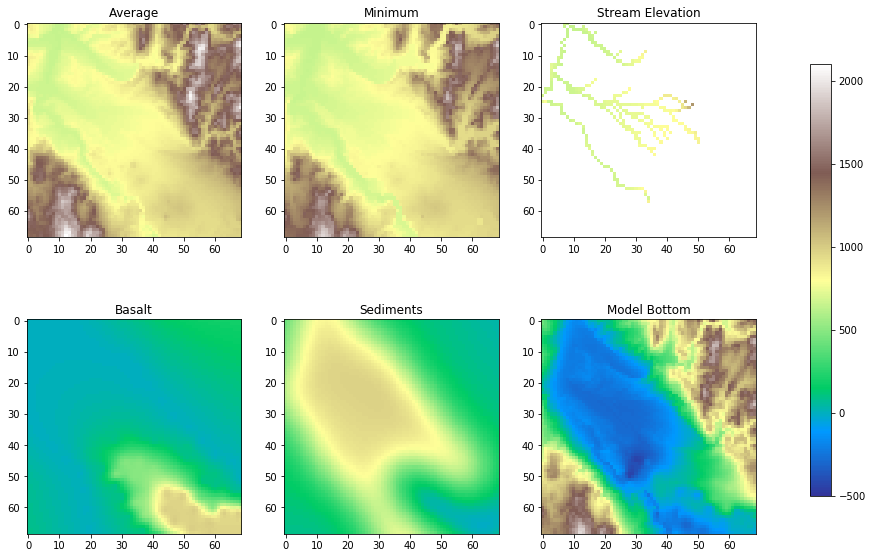

In [4]:
### 3.i. Plot up the DEMs
# mask for plotting river elevations only
mask = np.zeros(npDEM.shape,dtype=bool) 
mask[ arr_stream == 0 ] = True 
cmin = -500
cmax = np.ceil(npDEM.max()/100)*100
fig,ax = plt.subplots(2,3,figsize=(15,10))
ax=ax.ravel()
im = ax[0].imshow(DEMavg['raster'],cmap='terrain',vmin=cmin,vmax=cmax)
ax[1].imshow(DEMmin['raster'],cmap='terrain',vmin=cmin,vmax=cmax)
ax[2].imshow(np.ma.masked_array(DEMmin['raster'],mask),cmap='terrain',vmin=cmin,vmax=cmax)
ax[3].imshow(dbasalt['raster'],cmap='terrain',vmin=cmin,vmax=cmax)
ax[4].imshow(dseds['raster'],cmap='terrain',vmin=cmin,vmax=cmax)
ax[5].imshow(DEMbottom2,cmap='terrain',vmin=cmin,vmax=cmax)
ax[0].set_title('Average')
ax[1].set_title('Minimum')
ax[2].set_title('Stream Elevation')
ax[3].set_title('Basalt')
ax[4].set_title('Sediments')
ax[5].set_title('Model Bottom')
#### Colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6]) #l, b, w, h
fig.colorbar(im,cax=cbar_ax)
plt.show()

## Add a spatial reference to the model 

In [5]:
xll, yll = 2247000.00, 1330950.00          # origin of the model [m] (lower left corner)
dxdy = 1609.344                            # grid spacing (in model units) 
nrow , ncol = npDEM.shape
delc = np.ones(nrow, dtype=float) * dxdy   
delr = np.ones(ncol, dtype=float) * dxdy
nlay = 2                                   # Number of layers
ztop = npDEM                               # Top of model is the DEM we just created
botm = np.stack( (DEMbottom1,DEMbottom2))  # A 3D array defines the bottom of the two layers 
rot = -2                                   # rotation (positive ccw)
# Specify coordinate system with custom Proj4 string for IDTM83
model_proj4 = '+proj=tmerc +lat_0=42 +lon_0=-114 +k=0.9996 +x_0=2500000 +y_0=1200000 +ellps=GRS80 +units=m +no_defs'
sr = SpatialReference(delr=delr, delc=delc, xll=xll, yll=yll, rotation=rot, proj4_str = model_proj4)

#### Create model and discretization packages with ```Flopy```

In [6]:
# Initialize model object and discretization object
ml = flopy.modflow.Modflow(modelname = 'TV', exe_name = 'mf2005', model_ws = root )
dis = flopy.modflow.ModflowDis(ml, nlay ,nrow, ncol , delr=delr, delc=delc ,top=ztop, botm=botm)
# Here is where we update the model to include the spatial reference defined above
ml.sr = sr

#### Basic Package
Use the model boundary shapefile to set the ibound. In this example, a 2D array is input into the flopy module and it is assumed to be constant for all layers. We could create different arrays for each layer if we need.

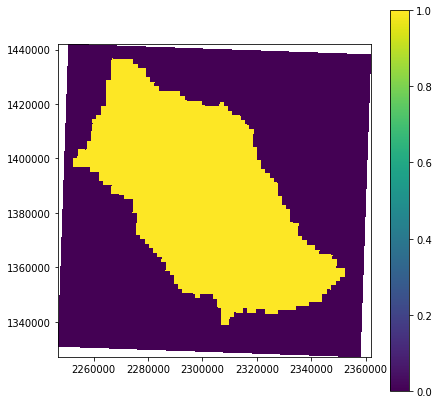

In [7]:
model_bound = os.path.join(root,'data','gis','TV_Bound_2010.shp')
rbound = vtorast(model_bound,cell_size=1609.344, bounds=region)
fig,ax = plt.subplots(1,1,figsize=(7,7))
qm = ml.sr.plot_array(rbound['raster'], ax=ax)
ax.set_aspect(1)
plt.colorbar(qm)
ibound = rbound['raster']
# Feed the rasterized boundary to the flopy 
bas = flopy.modflow.ModflowBas(ml, ibound=ibound)

In [37]:
from matplotlib import colors
# define the colormap
cmap = plt.cm.PuBuGn_r
# extract all colors from the color map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(-7,0,8)
norm = colors.BoundaryNorm(bounds, cmap.N)

## Create some apocryphal hydraulic conductivities
Use Pietrich's (2004) range of 0.001 - 1000 ft/day (1e-4 - 1000 m/day)

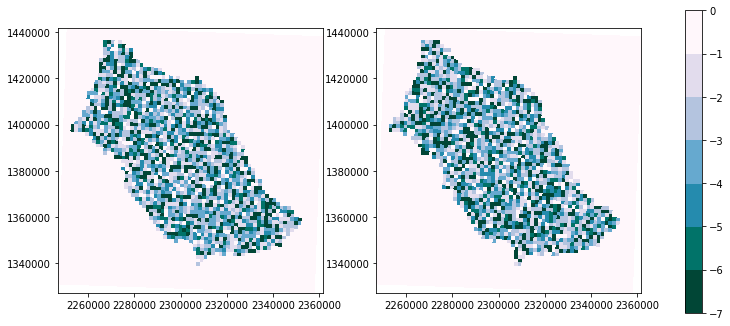

In [38]:
#cmap = 'bone'
np.random.seed(844391)
hk = np.random.uniform(1E-4,1E3,(2,69,69)) * ibound
hklog = np.random.uniform(-7,3,(2,69,69)) * ibound
# Randomize with a gamma scale
hklog= np.random.gamma(2,2,(2,69,69)) * -1 * ibound
fig,ax = plt.subplots(1,2,figsize=(12,7))
qm = ml.sr.plot_array(hklog[0,:,:], ax=ax[0],cmap=cmap,norm=norm)
ml.sr.plot_array(hklog[1,:,:],ax=ax[1],cmap=cmap,norm = norm)
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6]) #l, b, w, h
fig.colorbar(qm,cax=cbar_ax)

Let's filter the hydraulic condunctivities so they aren't so...discrete

In [40]:
from scipy.signal import medfilt2d
hklog= np.random.gamma(2.75,2,(2,69,69)) * -1
hkfilt1 = medfilt2d(hklog[0,:,:],5) * ibound
hkfilt2 = medfilt2d(hklog[1,:,:],5) * ibound
hkfilt = 10**np.stack((hkfilt1,hkfilt2))

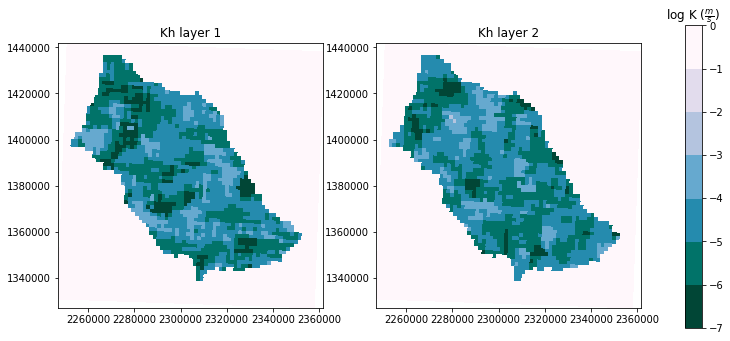

In [41]:
fig,ax = plt.subplots(1,2,figsize=(12,7))
qm = ml.sr.plot_array(hkfilt1, ax=ax[0],cmap=cmap,norm=norm)
ml.sr.plot_array(hkfilt2,ax=ax[1],cmap=cmap,norm=norm)
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[0].set_title('Kh layer 1')
ax[1].set_title('Kh layer 2')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6]) #l, b, w, h
fig.colorbar(qm,cax=cbar_ax)
cbar_ax.set_title(r'log K ($\frac{m}{s})$')

In [25]:
hkfilt[0,:,:][55]

array([  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.29756514e-05,   1.29756514e-05,
         7.09498434e-06,   7.09498434e-06,   7.09498434e-06,
         7.26228902e-06,   6.65146789e-06,   7.34224728e-06,
         7.34224728e-06,   3.88385699e-06,   1.97742578e-06,
         2.24357450e-06,   3.88385699e-06,   2.24357450e-06,
         4.94079301e-06,   2.01302564e-05,   2.01302564e-05,
         6.97900040e-06,   2.01302564e-05,   6.97900040e-06,
         1.06397251e-05,

#### Layer Property Flow:
Assign hydraulic conductivities with the LPF package. We'll make vertical conductivity 1% of horizontal

In [42]:
# Add LPF package to the MODFLOW model. Convert K_h in m s^-1 to m d^-1
lpf = flopy.modflow.ModflowLpf(ml, hk=hkfilt* 86400, vka= hkfilt*86400/100, ipakcb=53,laytyp = 1)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...


### Output Control

In [43]:
# Add OC package to the MODFLOW model
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd, compact=True)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


In [44]:
# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(ml)
# Update BAS to have heads start 30 m below land surface
strt1 = np.round(npDEM) - 20.
strt2 = np.round(DEMbottom2 + 1000)
bas.strt = np.stack((strt1,strt2))

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...


### Write input files and run model

In [45]:
ml.write_input()
# Run the MODFLOW model
success, buff = ml.run_model()

FloPy is using the following executable to run the model: D:\WRDAPP\mf2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: TV.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/05/15 11:42:56

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/05/15 11:42:56
 Elapsed run time:  0.106 Seconds

  Normal termination of simulation


## Post-process results

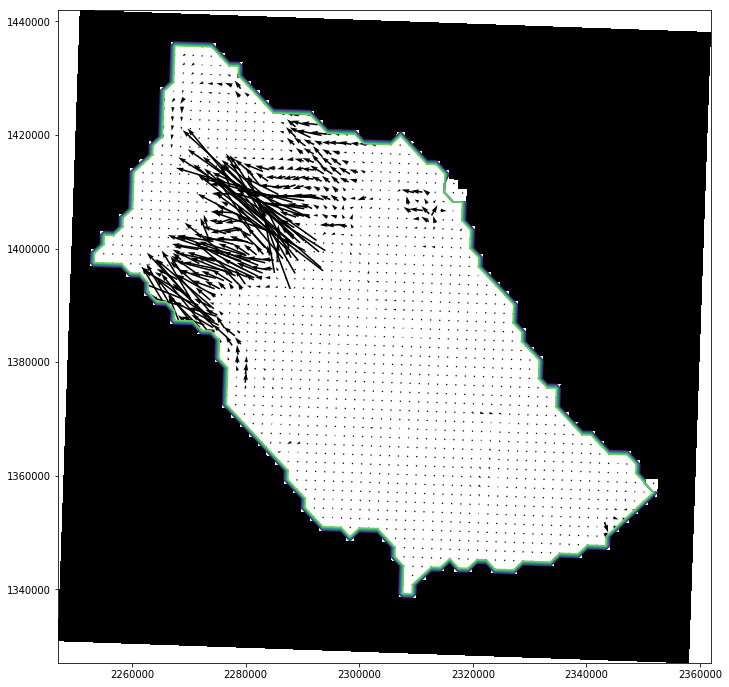

In [46]:
import flopy.utils.binaryfile as bf
modelname = 'TV'
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

hds = bf.HeadFile(modelname+'.hds')
times = hds.get_times()
head = hds.get_data(totim=times[-1])
levels = np.linspace(0, 1000, 10)

cbb = bf.CellBudgetFile(modelname+'.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.ModelMap(model=ml, layer=1)
qm = modelmap.plot_ibound()
#lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=levels)
quiver = modelmap.plot_discharge(frf, fff, head=head)
#plt.savefig('tutorial1b.png')

- list  3 SuperSS.lst
- BAS6  1 super.ba6
- bcf6 11 SuperSS.bc6
- oc   22 SS.ocl
- riv  14 super.riv
- ghb  15 super.ghb
- wel  18 SuperSS.wel
- pcg  23 standard.pcg
- DIS  10 SuperSS.dis
- data(binary)  50 SuperSS.bud
- data(binary)  51 SuperSS.hds


In [30]:
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt [:,:,]

In [33]:
sr.transform(2,3)
sr.get_rc(2320000,1350000)

(57, 42)

In [69]:
a = head[0,:,:]

In [70]:
plt.imshow(a)

array([-999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023,  806.09332275,  806.09332275,
        806.09332275,  806.09332275,  806.09332275,  806.09332275,
        806.09332275,  806.09332275,  806.09332275, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999023,
       -999.98999023, -999.98999023, -999.98999023, -999.98999